**Import necesseary libraries to make the project**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import glob as gb
import cv2
import tensorflow as tf
from tensorflow import keras
import plotly.express as px
import scipy as sp
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img
import random

In [ ]:
cd /content/drive/MyDrive/Neural network project

/content/drive/MyDrive/Neural network project


**Data directories**

In [ ]:
data = '/content/drive/MyDrive/Neural network project/3-kinds-of-pneumonia'
COVID = '/content/drive/MyDrive/Neural network project/3-kinds-of-pneumonia/Curated X-Ray Dataset/COVID-19'
Normal = '/content/drive/MyDrive/Neural network project/3-kinds-of-pneumonia/Curated X-Ray Dataset/Normal'
Bacterial = '/content/drive/MyDrive/Neural network project/3-kinds-of-pneumonia/Curated X-Ray Dataset/Pneumonia-Bacterial'
Viral = '/content/drive/MyDrive/Neural network project/3-kinds-of-pneumonia/Curated X-Ray Dataset/Pneumonia-Viral'

**Show sample of the data in ditecories**

In [ ]:
DATADIR = data
CATEGORIES=[Normal,COVID, Bacterial,Viral]

**Unify the image size**

In [ ]:
#resize photes 224*224
img_size = 224
training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num= CATEGORIES.index (category) 
        for img in tqdm (os.listdir (path)):
             try:
                    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) 
                    new_array = cv2.resize(img_array, (img_size, img_size)) 
                    training_data.append( [new_array, class_num])
             except Exception as e:
                pass
                    
create_training_data()

100%|██████████| 1656/1656 [00:35<00:00, 46.30it/s]


**Separate labels and inputs**

In [ ]:
x=[]
y=[]
for features,label in training_data:
    x.append(features)
    y.append(label)
x=np.array(x).reshape(-1,img_size,img_size, 3)#(number of photos,224,224,3)
y=np.array(y)

In [ ]:
x.shape , x[1].shape, 

((9208, 224, 224, 3), (224, 224, 3))

In [ ]:
dic = {
    0 : 'Normal',
    1 : 'COVID-19',
    2 : 'Pneumonia-Bacterial',
    3 : 'Pneumonia-Viral',
}
def getDiseaseName(code):
    for x,y in dic.items():
        if code==x:
            return y

In [ ]:
# To divide data to train and test and shuffle the
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [ ]:
print(f'X_train shape  is {x_train.shape}')
print(f'X_test shape  is {x_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (7826, 224, 224, 3)
X_test shape  is (1382, 224, 224, 3)
y_train shape  is (7826,)
y_test shape  is (1382,)


**Making the model using Transfer Learning**

In [ ]:
# Hyperparameters
IMG_IND = 224
IMG_SHAPE =(IMG_IND,IMG_IND,3)
IMG_SIZE = (224,224)
SEED = 2
BATCH_SIZE = 16

In [ ]:
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import Sequential
import keras 
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [ ]:
def get_callbacks(model_name):
    callbacks =[]
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto') 
    callbacks.append(anne)
    return callbacks

**DenseNet121 Model**

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile( loss='sparse_categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy' ]
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
callbacks = get_callbacks('dense121')
training_history = model.fit(x_train, y_train, validation_split=0.15, epochs=10, batch_size=64 ,callbacks=[callbacks])

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.8121
Epoch 1: val_loss improved from inf to 13.98976, saving model to model.dense121.h5
104/104 [==============================] - 181s 849ms/step - loss: 0.4505 - accuracy: 0.8121 - val_loss: 13.9898 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.8585
Epoch 2: val_loss improved from 13.98976 to 0.99765, saving model to model.dense121.h5
104/104 [==============================] - 76s 728ms/step - loss: 0.3269 - accuracy: 0.8585 - val_loss: 0.9977 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8629
Epoch 3: val_loss improved from 0.99765 to 0.83160, saving model to model.dense121.h5
104/104 [==============================] - 76s 734ms/step - loss: 0.3143 - accuracy: 0.8629 - val_loss: 0.8316 - val_accuracy: 0.7709 - lr: 0.0010
Epoch 4/10
10

In [ ]:
training_history = model.fit(x_train, y_train, validation_split=0.15, epochs=10, batch_size=64 ,callbacks=[callbacks])

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9952
Epoch 1: val_loss did not improve from 0.45233
104/104 [==============================] - 76s 725ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.6153 - val_accuracy: 0.8705 - lr: 2.5000e-04
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9998
Epoch 2: val_loss did not improve from 0.45233
104/104 [==============================] - 73s 698ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.4719 - val_accuracy: 0.9055 - lr: 2.5000e-04
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.45233
104/104 [==============================] - 73s 698ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.9089 - lr: 2.5000e-04
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 6.6790e-04 - accuracy: 1.0000
Epoch 4: val_loss 

In [ ]:
model.evaluate(x_test, y_test)

44/44 [==============================] - 7s 115ms/step - loss: 0.4737 - accuracy: 0.9030


[0.4736597537994385, 0.9030390977859497]

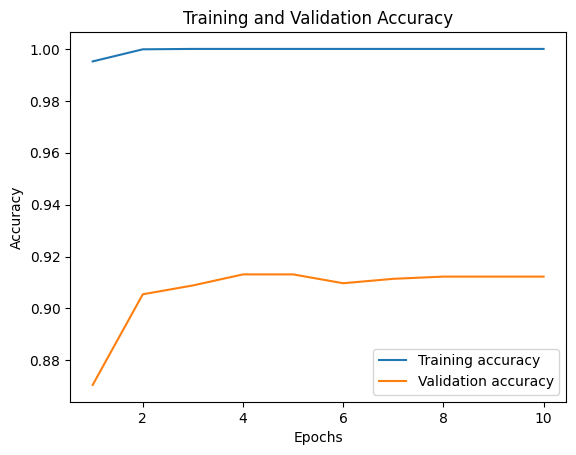

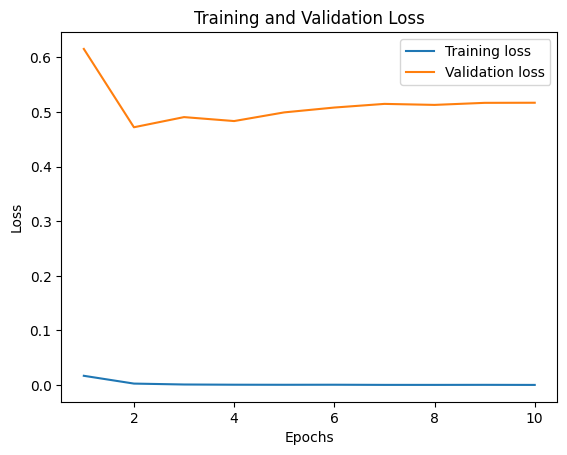

In [ ]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('TLDenseNet121v1.h5')

In [ ]:
y_pred = model.predict(x_test)

44/44 [==============================] - 5s 85ms/step


In [ ]:
y_test2 = y_test.flatten()
y_test2

array([0, 0, 2, ..., 0, 2, 2])

In [ ]:
y_hat = np.argmax(y_pred, axis=1)
y_hat

array([0, 0, 2, ..., 0, 2, 2])

              precision    recall  f1-score   support

      normal     0.9652    0.9833    0.9742       480
       covid     0.9948    0.9948    0.9948       194
   bacterial     0.8480    0.9000    0.8732       440
       viral     0.8060    0.6978    0.7480       268

    accuracy                         0.9030      1382
   macro avg     0.9035    0.8940    0.8976      1382
weighted avg     0.9012    0.9030    0.9011      1382



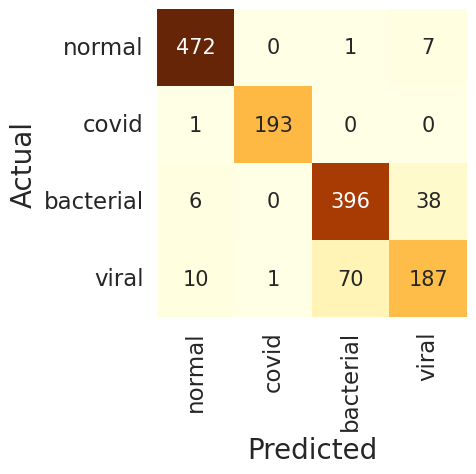

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

target_names = ['normal','covid','bacterial','viral']
report = classification_report(y_test2, y_hat, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_test2, y_hat)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

**MobileNet Model**

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile( loss='sparse_categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy' ]
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
callbacks = get_callbacks('MobileNetv2')
training_history = model.fit(x_train, y_train, validation_split=0.15, epochs=10, batch_size=64 ,callbacks=[callbacks])

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8268
Epoch 1: val_loss improved from inf to 10.31711, saving model to model.MobileNetv2.h5
104/104 [==============================] - 32s 309ms/step - loss: 0.4299 - accuracy: 0.8268 - val_loss: 10.3171 - val_accuracy: 0.2078 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8596
Epoch 2: val_loss improved from 10.31711 to 5.86732, saving model to model.MobileNetv2.h5
104/104 [==============================] - 28s 265ms/step - loss: 0.3287 - accuracy: 0.8596 - val_loss: 5.8673 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.8894
Epoch 3: val_loss did not improve from 5.86732
104/104 [==============================] - 26s 250ms/step - loss: 0.2573 - accuracy: 0.8894 - val_loss: 6.0206 - val_accuracy: 0.4106 - lr: 0.0010
Epoch 4/10
104/104 [===========================

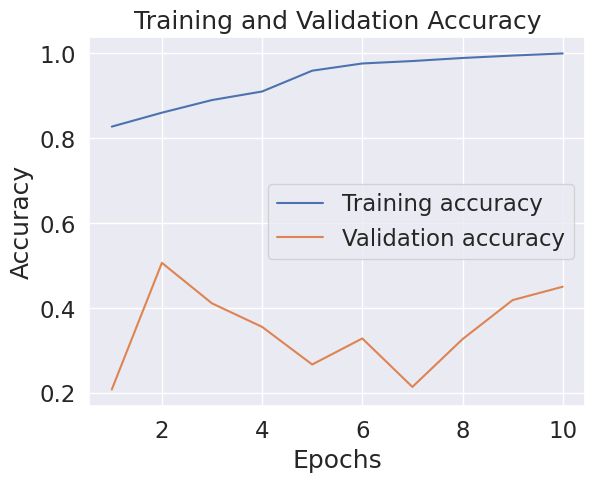

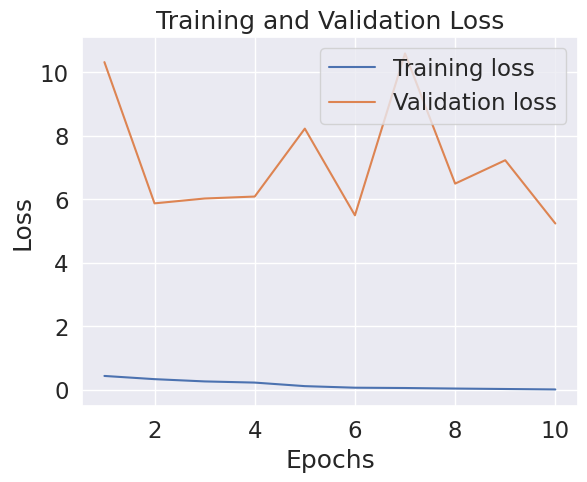

In [ ]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

44/44 [==============================] - 3s 46ms/step - loss: 5.8051 - accuracy: 0.4175


[5.805080890655518, 0.41751086711883545]

In [ ]:
y_pred = model.predict(x_test)

44/44 [==============================] - 2s 34ms/step


In [ ]:
y_test2 = y_test.flatten()
y_hat = np.argmax(y_pred, axis=1)

              precision    recall  f1-score   support

      normal     0.9286    0.1083    0.1940       480
       covid     1.0000    0.2474    0.3967       194
   bacterial     0.6421    0.5545    0.5951       440
       viral     0.2595    0.8694    0.3997       268

    accuracy                         0.4175      1382
   macro avg     0.7075    0.4449    0.3964      1382
weighted avg     0.7176    0.4175    0.3901      1382



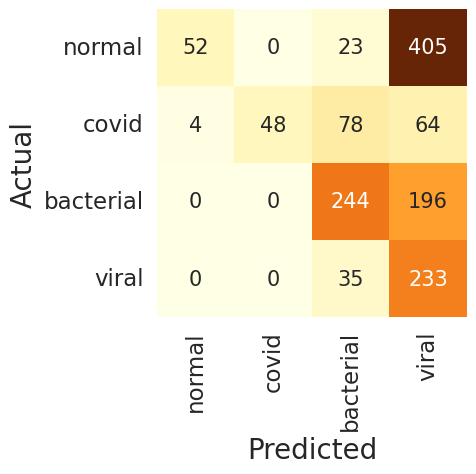

In [ ]:
target_names = ['normal','covid','bacterial','viral']
report = classification_report(y_test2, y_hat, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_test2, y_hat)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

**Xception Model**

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile( loss='sparse_categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy' ]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
callbacks = get_callbacks('Xception')
training_history = model.fit(x_train, y_train, validation_split=0.15, epochs=10, batch_size=64 ,callbacks=[callbacks])

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8214
Epoch 1: val_loss improved from inf to 1.28439, saving model to model.Xception.h5
104/104 [==============================] - 175s 1s/step - loss: 0.4363 - accuracy: 0.8214 - val_loss: 1.2844 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8778
Epoch 2: val_loss improved from 1.28439 to 0.52060, saving model to model.Xception.h5
104/104 [==============================] - 118s 1s/step - loss: 0.2924 - accuracy: 0.8778 - val_loss: 0.5206 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9045
Epoch 3: val_loss did not improve from 0.52060
104/104 [==============================] - 107s 1s/step - loss: 0.2382 - accuracy: 0.9045 - val_loss: 0.5667 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 4/10
104/104 [==============================] - ETA: 0s 

In [ ]:
model.evaluate(x_test, y_test)

44/44 [==============================] - 8s 142ms/step - loss: 0.5211 - accuracy: 0.9016


[0.5211457014083862, 0.9015918970108032]

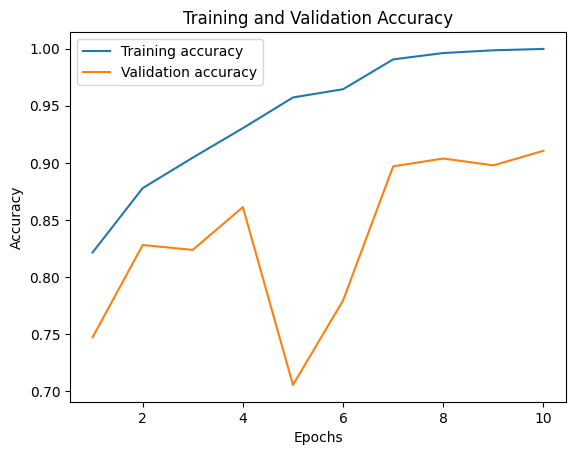

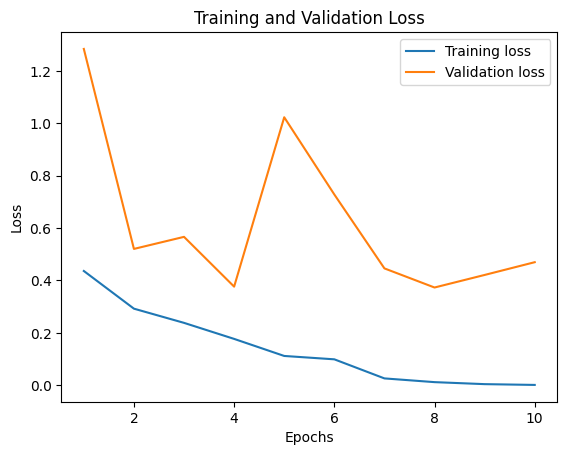

In [ ]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(x_test)

44/44 [==============================] - 6s 131ms/step


In [ ]:
y_test2 = y_test.flatten()
y_hat = np.argmax(y_pred, axis=1)

              precision    recall  f1-score   support

      normal     0.9593    0.9833    0.9712       480
       covid     1.0000    0.9897    0.9948       194
   bacterial     0.8562    0.8932    0.8743       440
       viral     0.7908    0.7052    0.7456       268

    accuracy                         0.9016      1382
   macro avg     0.9016    0.8929    0.8965      1382
weighted avg     0.8995    0.9016    0.8999      1382



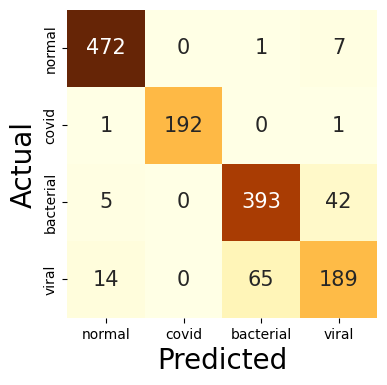

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

target_names = ['normal','covid','bacterial','viral']
report = classification_report(y_test2, y_hat, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_test2, y_hat)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

**VGG16 Model**

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile( loss='sparse_categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy' ]
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
callbacks = get_callbacks('VGG16')
training_history = model.fit(x_train, y_train, validation_split=0.15, epochs=10, batch_size=64 ,callbacks=[callbacks])

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 4.5436 - accuracy: 0.3456
Epoch 1: val_loss improved from inf to 1.37915, saving model to model.VGG16.h5
104/104 [==============================] - 142s 1s/step - loss: 4.5436 - accuracy: 0.3456 - val_loss: 1.3792 - val_accuracy: 0.3450 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 1.3457 - accuracy: 0.3716
Epoch 2: val_loss improved from 1.37915 to 1.27803, saving model to model.VGG16.h5
104/104 [==============================] - 89s 858ms/step - loss: 1.3457 - accuracy: 0.3716 - val_loss: 1.2780 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 1.1489 - accuracy: 0.5421
Epoch 3: val_loss improved from 1.27803 to 1.12302, saving model to model.VGG16.h5
104/104 [==============================] - 91s 876ms/step - loss: 1.1489 - accuracy: 0.5421 - val_loss: 1.1230 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 4/10
104/104 [========

In [ ]:
model.evaluate(x_test,y_test)

44/44 [==============================] - 10s 145ms/step - loss: 0.9020 - accuracy: 0.5977


[0.9019593596458435, 0.5976845026016235]

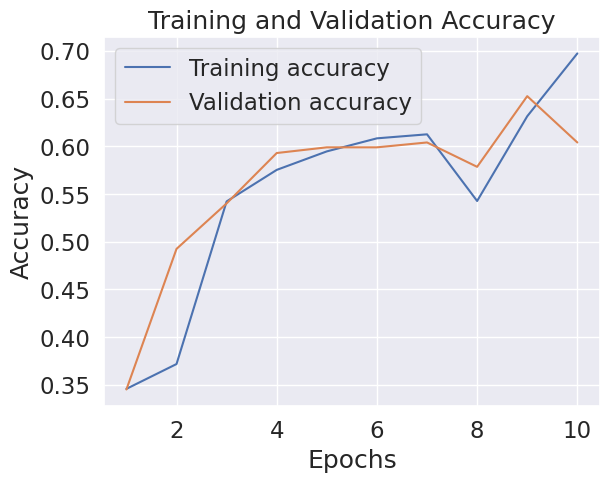

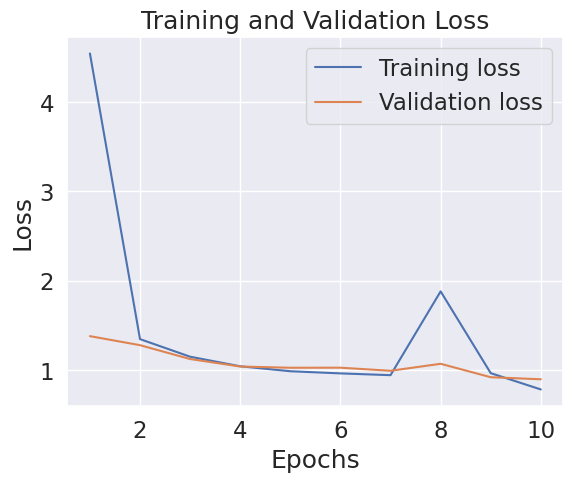

In [ ]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(x_test)

44/44 [==============================] - 5s 117ms/step


In [ ]:
y_test2 = y_test.flatten()
y_hat = np.argmax(y_pred, axis=1)

              precision    recall  f1-score   support

      normal     0.9275    0.5333    0.6772       480
       covid     0.8010    0.8299    0.8152       194
   bacterial     0.4539    0.9295    0.6100       440
       viral     0.0000    0.0000    0.0000       268

    accuracy                         0.5977      1382
   macro avg     0.5456    0.5732    0.5256      1382
weighted avg     0.5791    0.5977    0.5439      1382



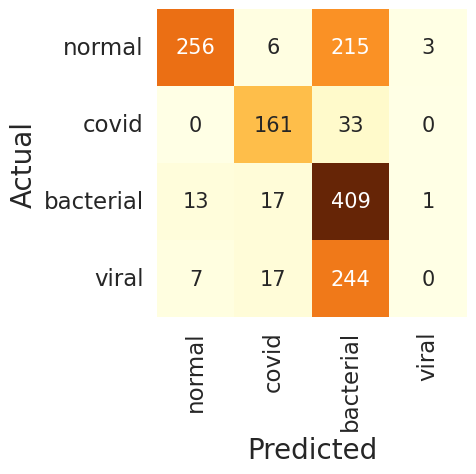

In [ ]:
target_names = ['normal','covid','bacterial','viral']
report = classification_report(y_test2, y_hat, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_test2, y_hat)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()